# Monitor Segmentation pipeline

## Overview

The first step in extracting information from the ICU monitor is to remove background elements, and make the monitor screen occupy as much space as possible, while accounting for perespective distortions. 

We achieve this in two steps

1. Segmentation of the monitor screen
2. Warping of the segmented screen to get the monitor in a front-facing orientation

## Segmentation
* We tried two models for segmentation of the monitor screen, Yolo and Detectron2. YOLO was chosen as our primary model because of its better speed and testing accuracy.
* After segmentation, we used Perspective Transformation function to get a rectified image of the monitor. 



<!-- Todo: 

*   Add support for directory input
*   Update the repo to include a sneaky runs/seg-predict/exp/ folder to solve the interator value problem
*   Properly process multiple output
*   Import the custom git repo in python itself
*   Needs more investigation in the openCV portion -->




# Imports and mounts


In [ ]:
!git clone https://github.com/ultralytics/yolov5    #update weights and add to file
#todo - add runs/predict-seg/exp/ so that i=1 makes the runinference function work properly
#issue - file names ending with 'image' get cut - find out how rstrip works, and use slicing instead

Cloning into 'yolov5'...
remote: Enumerating objects: 15070, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 15070 (delta 25), reused 30 (delta 13), pack-reused 15019
Receiving objects: 100% (15070/15070), 14.13 MiB | 19.11 MiB/s, done.
Resolving deltas: 100% (10324/10324), done.


In [ ]:
# get the weights - trained on yolov5n 
!gdown 10FTRA1EBIbENR579vdam8CNPA0Zw5PMB

Downloading...
From: https://drive.google.com/uc?id=10FTRA1EBIbENR579vdam8CNPA0Zw5PMB
To: /content/best.pt
100% 4.04M/4.04M [00:00<00:00, 208MB/s]


In [ ]:
%cd yolov5
!pip install -r requirements.txt

/content/yolov5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.1 MB/s eta 0:00:00


In [ ]:
# %cd segment

In [ ]:
import segment.predict as predict

In [ ]:
import numpy as np
import os
import cv2
from google.colab.patches import cv2_imshow
import subprocess
import matplotlib.pyplot as plt
import timeit
import time
import torch
%matplotlib inline

In [ ]:
def plotimk(im_list, title_list,k):  # To plot a list of images and their titles
  '''
  Image processing function
  Inputs: List of images
          List of respective image labels
          Number of images to show per row
  Outputs: A subplot with images and labels as provided in the input
  '''
  import math
  nrows = math.ceil(len(im_list)/k)
  fig, ax = plt.subplots(nrows, k, figsize=(nrows*30, 50))
  if nrows==1:
    for i in range(len(im_list)):
      ax[i%k].imshow(im_list[i])
      ax[i%k].set_title(title_list[i], size=22)
  else:
    for i in range(len(im_list)):
      ax[i//k, i%k].imshow(im_list[i])
      ax[i//k, i%k].set_title(title_list[i], size=22)
  plt.show()   

## Depreciated code

Reasons specified in code

In [ ]:
####### DEPRECIATED - DIDNT WORK ANYWAY #######

def runInference2(filename):
  '''
  Run prediction on the image
  Inputs: Absolute file path relative to working directory or absolute file path
  Outputs: None (passes a command line argument for YOLO to run prediction)
  '''
  # time.sleep(1)
  os.system('python segment/predict.py --weights models/last.pt --source '+str(filename)+' --hideconf --hide-labels --save-txt')
  time.sleep(1)



### Passing input to the terminal thorugh python 
Achieved using `subprocess` library

Decided to not use as `subprocess` was exceedingly slow (segmentation pipeline itself took more than 4 seconds per image)

In [ ]:
###### DEPRECIATED - SUBPROCESS IS TOO SLOW ########

def runInference(filename):         #pass command line input to run YOLO on the image
  '''
  Run prediction on the image
  Inputs: Absolute file path relative to working directory or absolute file path
  Outputs: None (passes a command line argument for YOLO to run prediction)
  '''
  op=subprocess.check_output(['python','segment/predict.py','--weights','models/last.pt','--source',str(filename),'--hide-conf','--hide-labels','--save-txt'])
  # os.system('python segment/predict.py --weights /content/drive/MyDrive/Segmentation/Yolov7 weights/Yolov5 Segmentation 608px/exp5/weights/best.pt --source '+str(filename)+' --save-txt --hide-conf --hide-labels ')
  return op

In [ ]:
###### DEPRECIATED - USELESS AFTER getcorners2() ######

def getbbox(filename,image,i):      #get bounding box points
  bbox=[]
  with open('runs/predict-seg/exp'+str(i)+'/labels/'+filename.rstrip('.jpeg')+'_bbox.txt') as f:
    # w, h = [int(x) for x in next(f).split()] # read first line
    array = []
    for x in next(f).split():
        array.append(float(x))
    # temp=cv2.imread('/content/yolov5/kamalnayanbajaj_micu_mon--15_2022_6_20_21_46_20.jpeg')
    bbox.append([np.int32((array[1]-(array[3])/2)*image.shape[1]),np.int32((array[2]-(array[4])/2)*image.shape[0])])
    bbox.append([np.int32((array[1]+(array[3])/2)*image.shape[1]),np.int32((array[2]-(array[4])/2)*image.shape[0])])
    bbox.append([np.int32((array[1]+(array[3])/2)*image.shape[1]),np.int32((array[2]+(array[4])/2)*image.shape[0])])
    bbox.append([np.int32((array[1]-(array[3])/2)*image.shape[1]),np.int32((array[2]+(array[4])/2)*image.shape[0])])
  return bbox

### Getting corners using proximity to corners of edge bounding boxes

Achieved by a simple minimization search. Was incorrect as cases exist which give worse output
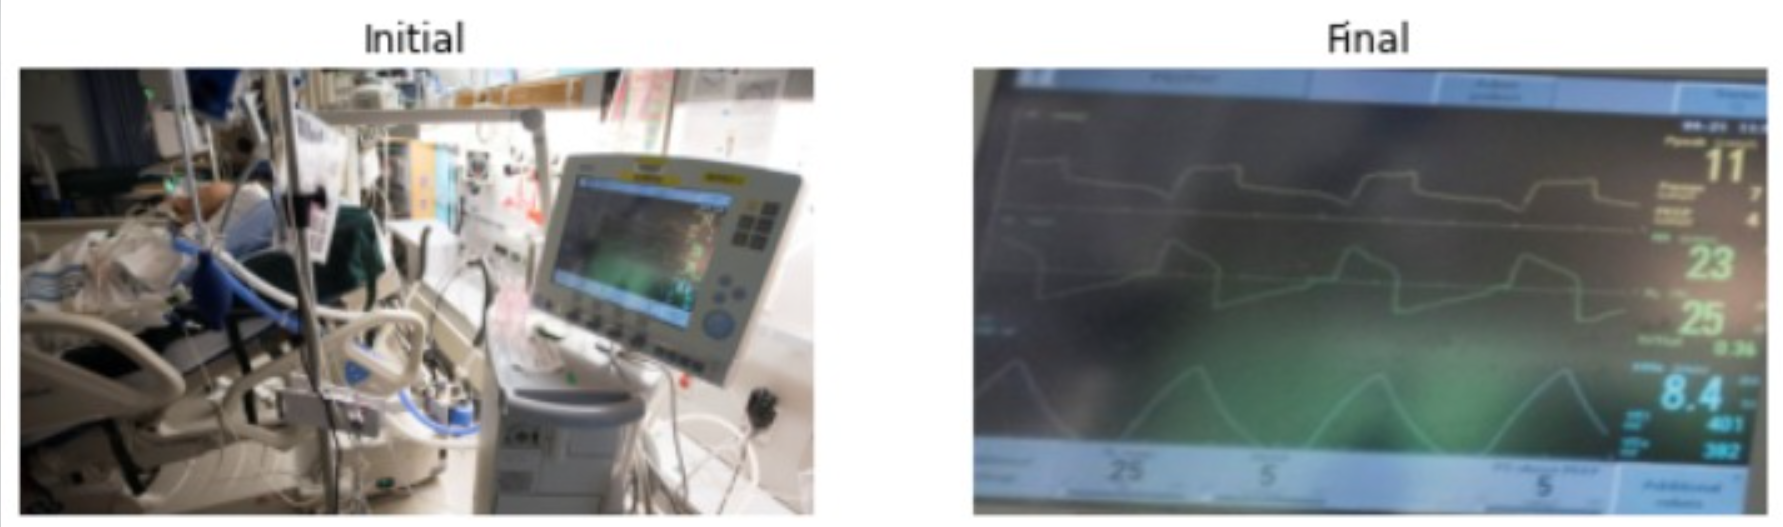
As is clearly visible, the monitor boundary casing is visible in the top left and bottom right corners of this image. Much better results were obtained using openCV, as shown below.


In [ ]:
###########  DEPRECIATED -  REFER TO THE ABOVE FUNCTION - IT WORKS BETTER ##########

def dis(a,b,c,d):            #distance function
  # print(a,b,c,d)
  return abs((a-c)*(a-c)+(b-d)*(b-d))

def getcorners(bbox,mbox):   #get corners (approximately)
  bboxa=bbox[0]
  bboxb=bbox[1]
  bboxc=bbox[2]
  bboxd=bbox[3]
  inf=1000000000
  pta=[inf,inf]
  ptb=[inf,inf]
  ptc=[inf,inf]
  ptd=[inf,inf]
  dmina=inf
  dminb=inf
  dminc=inf
  dmind=inf
  for c in mbox:
    x=c[0]
    y=c[1]
    # print(c,dis(x,y,pta[0],pta[1]))
    if(dis(x,y,bboxa[0],bboxa[1])<dmina):
      dmina=dis(x,y,bboxa[0],bboxa[1])
      pta=[np.int32(x),np.int32(y)]
    if(dis(x,y,bboxb[0],bboxb[1])<dminb):
      dminb=dis(x,y,bboxb[0],bboxb[1])
      ptb=[np.int32(x),np.int32(y)]
    if(dis(x,y,bboxc[0],bboxc[1])<dminc):
      dminc=dis(x,y,bboxc[0],bboxc[1])
      ptc=[np.int32(x),np.int32(y)]
    if(dis(x,y,bboxd[0],bboxd[1])<dmind):
      dmind=dis(x,y,bboxd[0],bboxd[1])
      ptd=[np.int32(x),np.int32(y)]
  pta[0]-=5
  pta[1]-=5
  ptb[0]+=5
  ptb[1]-=5
  ptc[0]+=5
  ptc[1]+=5
  ptd[0]-=5
  ptd[1]+=5
  return [pta,ptb,ptc,ptd]


# Functions
Short descriptions of each function have been added in the first line of each cell, and the large-scale function of some significant functions have been discussed in the next section

In [ ]:
#import the image
def importimage(filename):
  image=cv2.imread(filename)
  # print(widt,heigt)
  return image 

In [ ]:
#runs the imported yolov5 segmentation predict function from inside python, while specifying appropriate parameters
def runInferencenew(filename,input_dir):
  op=predict.run(weights='/content/best.pt',save_txt=True,source=filename,exist_ok=True,nosave=True)
  print(op)
  return op

YOLO prediction writes the coordinates of the mask's bounding box coordinates into a text file, which is then read to obtain the points. While less elegant, the method is necessary since the Torchub implementation fo YOLOv5 currently does not support mounting of custom segmentation weights for the model.

In [ ]:
#get all mask boundary points
def getmbox(filename,image,input_dir):      
  with open('/content/yolov5/runs/predict-seg/exp/labels/'+filename[len(input_dir):].rstrip('jpeg')+'txt') as f:
    bbox=[]
    fl=0
    t=[]
    for x in next(f).split():       #reading file
      if fl==0:
        fl+=1
        continue
      if fl%2==0:
        t.append(float(x)*image.shape[0])
        bbox.append(t.copy())
      else:
        t.append(float(x)*image.shape[1])
      if(fl%2==0):
        t.clear()
      fl+=1
  return bbox 

The function below uses opencv `approxPolyDP()` to generate 4 points on the boundary of a segmented mask. It uses binarization and blurring on the polygon defined by the mask of the ICU monitor and approximates the contours using a contour approximation. A tight contour approximation of error at most 0.05 time the perimeter provides best results, as in the case of roughly quadrilateral shaped bounding box, the approximation picks out the corners with a very high degree of accuracy.
<img src='https://drive.google.com/uc?id=1D_WzD2gA-buKOD0P0MC9SjWoPSlxpUCD'>
Comparing with `getcorners()`, the segmentation is much more accurate, as is visible by the absence of monitor corners in this example
<img src='https://drive.google.com/uc?id=1V2o22MmJDBKdjTW_1cVyGyYgPY7wplPU'>


In [ ]:
#distance metric for the opencv function
def dis2(c,d):
  return c*c+d*d

#get 'corner' coordinates using openCV
def getcorners2(filename,image,mbox):       #opencv corner coordinate function
  nim2=np.zeros((image.shape[0],image.shape[1],image.shape[2]))
  # cv2_imshow(cv2.fillConvexPoly(org_image.copy(),np.array(mbox,np.int32),color=(255,255,255)))
  nim=cv2.fillConvexPoly(nim2.copy(),np.array(mbox,np.int32),color=(255,255,255))
  # cv2_imshow(nim)
  img=nim.copy()
  # print(img.shape)
  gray = cv2.cvtColor(np.float32(img), cv2.COLOR_BGR2GRAY)
  # cv2_imshow(gray)
  # print(gray.shape)
  blurred = cv2.bilateralFilter(gray, 9, 75, 75)                          #smoothes out the noise in the image
  _, thresh = cv2.threshold(np.uint8(blurred), 0, 255, cv2.THRESH_OTSU)   #automatic image thresholding

  contours, _ = cv2.findContours(np.uint8(blurred), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contour = contours[0]

  perimeter = cv2.arcLength(contour, True)
  approx = cv2.approxPolyDP(contour, 0.05 * perimeter, True)

  for point in approx:
      x, y = point[0]
      cv2.circle(img, (x, y), 3, (0, 255, 0), -1)
  cv2.drawContours(img, [approx], -1, (0, 255, 0),3)
  # plotim(nim,img)
  dmin=10000000000
  ireq=-1
  for i in range(4):
    if dis2(approx[i][0][0],approx[i][0][1])<dmin:
      ireq=i
      dmin=dis2(approx[i][0][0],approx[i][0][1])
  # print([approx[ireq][0],approxpts[(ireq-1+4)%4][0],approxpts[(ireq-2+4)%4][0],approxpts[(ireq-3+4)%4][0]])
  return [approx[ireq][0],approx[(ireq-1+4)%4][0],approx[(ireq-2+4)%4][0],approx[(ireq-3+4)%4][0]]

# **Warping**

The warping function takes in the input of the corners of the monitor screen and changes the spatial layout of the image to give a straight and rectified image of the monitor. 

Warping goes through 2  OpenCV methods to give us the output image.

1. **getPerspectiveTransform()**
  * This method takes in coordinates of the corners of the ROI and calculates the Transormation Matrix needed for the warp.

 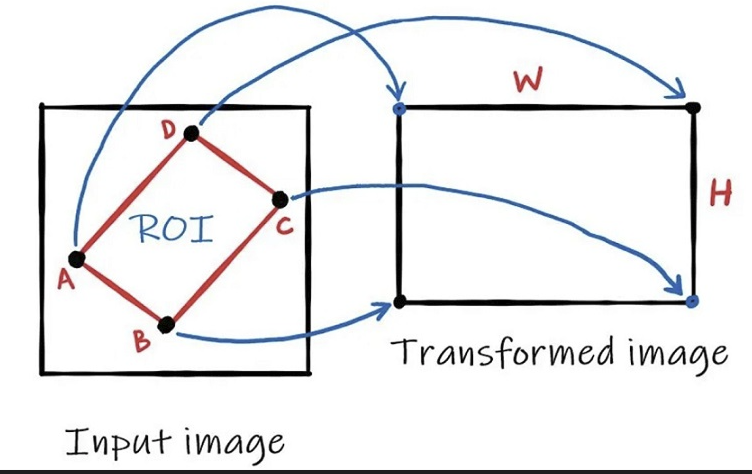


2. **warpPerspective()**
  * After the transformation matrix is calculated we apply it to the entire image to get the final output image.

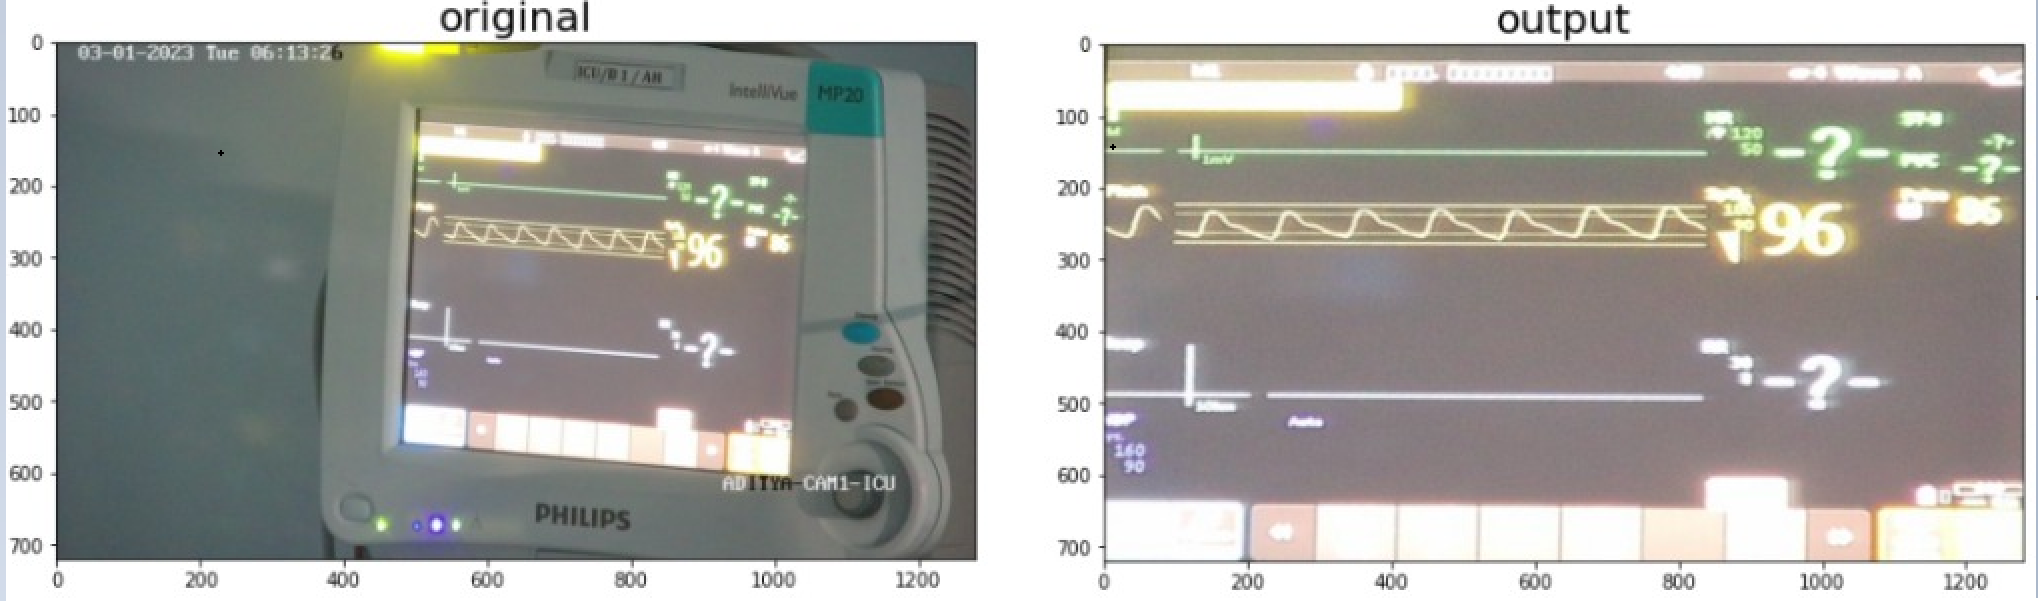




## **Affine Transformation**

* Affine tranformation is a type of image transformation that can change the shape, size, orientation and position of an image. 

*  It can only preserve parallelism and ratios of distances, but not ratios of areas or angles.


*We experimented with Affine Transformation to get a better view of the monitor, but decided to go ahead with warping, because:*

-> *Warping is a more flexible and powerful image transformation technique compared to Affine transformation, as it can preserve the relationship between points in the image.*

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def warpimage(image,corners):        #apply warping to the image
  # url = "/content/yolov5/kamalnayanbajaj_micu_mon--15_2022_6_20_21_46_20.jpeg"
  # x1, y1 = [500, 190]   
  # x2, y2 = [790, 220]
  # x3, y3 = [787, 497]
  # x4, y4 = [504, 452]
  # print(corners)
  cornersp = np.float32([corners[0], corners[1], corners[2], corners[3]])

  # img = cv2.imread(filename)
  width, height = image.shape[1],image.shape[0]
  pts2 = np.float32([[0,0],[width,0],[width,height],[0,height]])
  matrix = cv2.getPerspectiveTransform(cornersp,pts2)
  output = cv2.warpPerspective(image,matrix,(width,height))
  # cv2_imshow(image)
  # cv2_imshow(output)
  return output
  # cv2.waitKey(0)
  # cv2.imwrite('/content/yolov5/theimage.png',output)


In [ ]:
#input a list of filenames

# Run the segmentation + warping
def getWarpedImage(filenames,input_dir):
  t=0
  outputArray = []
  for filename in filenames:
    # try:
      # t_simp=time.time()
      image = importimage(filename)
      # t_eimp=time.time()
      # print('import time :',t_eimp-t_simp)
      # t_sinf=time.time()
      runInferencenew(filename,input_dir)
      # print("real inference time :",timetaken)
      # t_einf=time.time()
      # print('inference time :',t_einf-t_sinf)
      # t_smbox=time.time()
      mbox=getmbox(filename,image,input_dir)
      # t_embox=time.time();
      # print('mbox time :',t_embox-t_smbox)

      seg_img = cv2.polylines(image.copy(),np.array([mbox],np.int32),isClosed=True,color=(255,255,0),thickness=3)

      # bbox=getbbox(filename,image,i)
      # coords=getcorners(bbox,mbox)
      # t_sco=time.time()
      coords=getcorners2(filename,image,mbox)  #openCV corner function
      # t_eco=time.time()
      # print('getcorners2 time :',t_eco-t_sco)
      # print(coords)
      # t_sw=time.time()
      final=warpimage(image,coords)
      # t_ew=time.time()
      # print('warp time :',t_ew-t_sw)
      # cv2_imshow(final)
      plotimk([image,seg_img, final], ['Original img', 'After Segmentation', 'After Segmentation + Warping'],3)
      # cv2_imshow(final)
      cv2.imwrite('/content/'+  (filename[len(input_dir):]).split('.')[0] + 'sw.jpg'   ,final)
      # t_spl=time.time()
      # t_epl=time.time()
      # print('plotting time :',t_epl-t_spl)
      outputArray.append((final, seg_img))
  return outputArray
    # except Exception:
      # t+=1
  # print('Failed on ', t, 'tests')
                       #pipeline output

# Run the code

The function below will run the code on an image of the user's choice. 
1. Specify the input path of time image in the images list
2. Specify the input directory of the images(must be / terminated)
3. Run the cell

<img src='https://drive.google.com/uc?id=1hYywquRXwvU4Gqs8gGxx2i19jR1OLn8W'>

YOLOv5 🚀 v7.0-80-gc3c8e71 Python-3.8.10 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 165 layers, 1879750 parameters, 0 gradients, 6.7 GFLOPs
image 1/1 /content/adityawarangal_icu_mon--06_2023_1_5_19_15_26.jpeg: 384x640 1 screen, 113.3ms
Speed: 1.1ms pre-process, 113.3ms inference, 0.8ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/predict-seg/exp
1 labels saved to runs/predict-seg/exp/labels


None


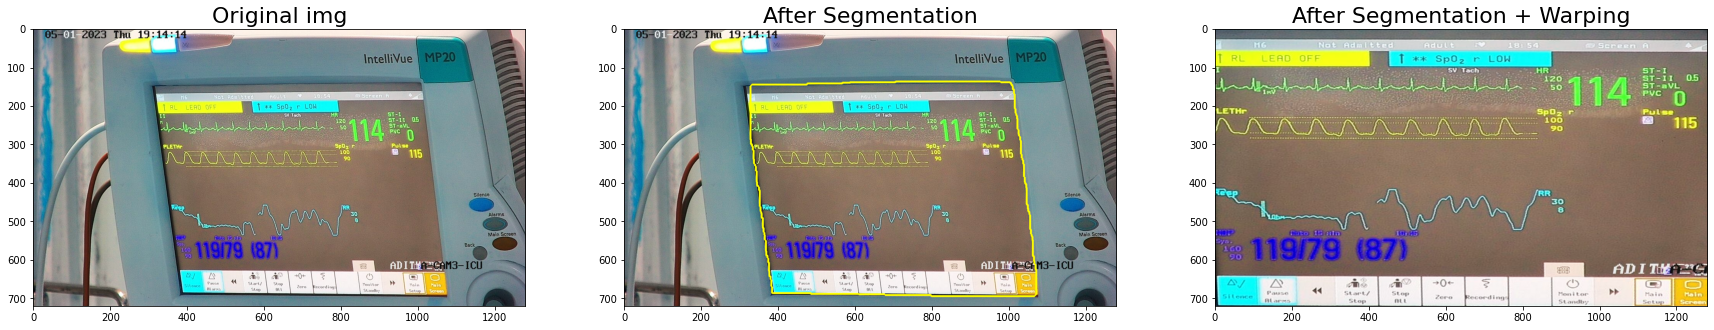

In [ ]:
images=['/content/adityawarangal_icu_mon--06_2023_1_5_19_15_26.jpeg']                                  #relative to root directory
input_dir='/content/'                                              #relative to root directory
output=[]
output.append(getWarpedImage(images,input_dir))

# Junk
Not to be submitted, baad me delete karne hai

In [ ]:
class LoadImagesFromList:
  def __init__(self, list_images):
    self.list_images = list_images
    self.nf = len(list_images)

  def __iter__(self):
    self.count = 0
    return self

  def __next__(self):
    if self.count == self.nf:
        raise StopIteration
    img = self.list_images[self.count]
    img = letterbox(img0, self.img_size, stride=self.stride)[0]

    # Convert
    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
    img = np.ascontiguousarray(img)
    self.count += 1

    return img

    def __len__(self):
        return self.nf  # number of files

In [ ]:
dataset2 = LoadImagesFromList(outputs)

In [ ]:
for img in dataset2:
  # print(img[0])
  runsegmentation(img[0],input_dir)

AttributeError: ignored

# Testing


YOLOv5 🚀 3dc0e9f Python-3.8.10 torch-1.13.1+cu116 CPU

Fusing layers... 


import time : 0.018103599548339844


Model summary: 165 layers, 1879750 parameters, 0 gradients, 6.7 GFLOPs
image 1/1 /content/quickbrownfoxx/WhatsApp Image 2023-01-31 at 11.16.07 PM.jpeg: 384x640 1 screen, 100.6ms
Speed: 0.9ms pre-process, 100.6ms inference, 0.7ms NMS per image at shape (1, 3, 640, 640)
Results saved to ../runs/predict-seg/exp
2 labels saved to ../runs/predict-seg/exp/labels


None
real inference time : None
inference time : 0.3643012046813965
mbox time : 0.0037827491760253906
getcorners2 time : 0.055205345153808594
warp time : 0.009150266647338867
plotting time : 1.9073486328125e-06


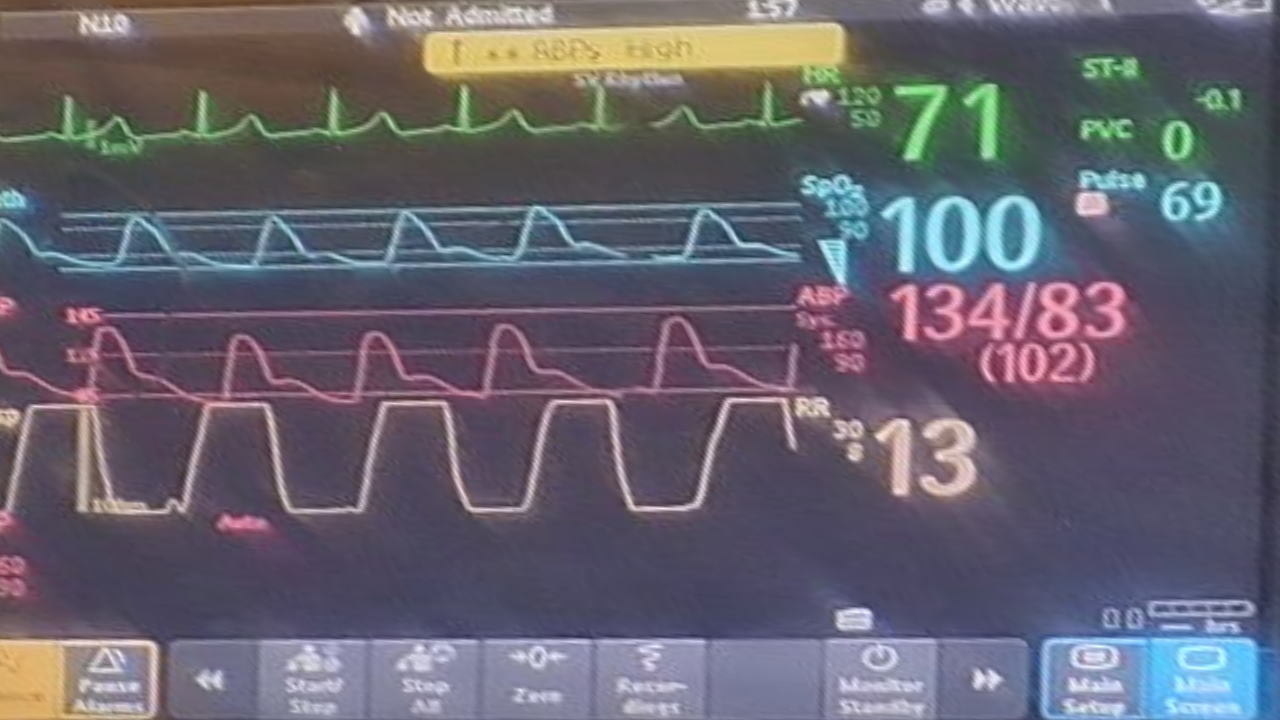

total time : 0.7857470512390137


In [ ]:
images=['/content/quickbrownfoxx/WhatsApp Image 2023-01-31 at 11.16.07 PM.jpeg']                                  #relative to root directory
input_dir='/content/quickbrownfoxx/'                                               #relative to root directory
output=[]
t_s=time.time()
cv2_imshow(runsegmentation(images,input_dir))
t_e=time.time()
print('total time :',t_e-t_s)

In [ ]:
!sudo apt-get install unzip


Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-25ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.


In [ ]:
!unzip /content/drive/MyDrive/Segmentation/Unlabelled\ Dataset.zip -d /content/quickbrownfoxx/Unlabelled

In [ ]:
!pwd

/content/quickbrownfoxx/segment


In [ ]:
import glob 
len(glob.glob('/content/quickbrownfoxx/Unlabelled/Unlabelled Dataset/*.jpeg'))

7000

In [ ]:
images=[filename for filename in glob.glob('/content/quickbrownfoxx/Unlabelled/Unlabelled Dataset/*.jpeg')]#relative to root directory
input_dir='/content/quickbrownfoxx/Unlabelled/Unlabelled Dataset/'                                               #relative to root directory
output=[]
t_s=time.time()
output.append(runsegmentation(images,input_dir))
t_e=time.time()
print('total time :',t_e-t_s)

YOLOv5 🚀 3dc0e9f Python-3.8.10 torch-1.13.1+cu116 CPU

Fusing layers... 


import time : 0.008984804153442383


Model summary: 165 layers, 1879750 parameters, 0 gradients, 6.7 GFLOPs
image 1/1 /content/quickbrownfoxx/Unlabelled/Unlabelled Dataset/msramaiahmemorialhospital_hdu_mon--2_2023_1_4_17_40_19.jpeg: 384x640 1 screen, 104.1ms
Speed: 0.7ms pre-process, 104.1ms inference, 1.2ms NMS per image at shape (1, 3, 640, 640)
Results saved to ../runs/predict-seg/exp
4 labels saved to ../runs/predict-seg/exp/labels


None
real inference time : None
inference time : 0.34716176986694336
mbox time : 0.001123189926147461
getcorners2 time : 0.07273483276367188
warp time : 0.008092164993286133
plotting time : 2.1457672119140625e-06
total time : 0.6632781028747559


In [ ]:
%cp -r /content/quickbrownfoxx/runs/predict-seg/exp /content/drive/MyDrive/Segmentation/Unlabelled\ extr

In [ ]:
len(glob.glob('/content/drive/MyDrive/Segmentation/Unlabelled extr/exp/*.jpeg'))

142

In [ ]:
print('/content/yolov5/runs/predict-seg/exp/labels/'+'/content/quickbrownfoxx/adityawarangal_icu_mon--01_2023_1_3_5_15_1.jpeg'.lstrip('/content/quickbrownfoxx/').rstrip('jpeg')+'txt')

/content/yolov5/runs/predict-seg/exp/labels/adityawarangal_icu_mon--01_2023_1_3_5_15_1.txt


In [ ]:
t_s=time.time()
runsegmentations(['adityawarangal_icu_mon--01_2023_1_3_5_15_1.jpeg','aastha_icu_mon--5_2023_1_2_9_0_0.jpeg','adityawarangal_icu_mon--02_2023_1_2_4_15_24.jpeg','adityawarangal_icu_mon--06_2023_1_4_18_15_27.jpeg','adityawarangal_icu_mon--06_2023_1_5_19_15_26.jpeg','aveksha_micu_mon--202_2023_1_2_20_0_1.jpeg','aveksha_micu_mon--202_2023_1_5_15_0_1.jpeg'],76)
t_e=time.time()
print('total time :',t_e-t_s)

NameError: ignored

In [ ]:
plotim(cv2.imread('/content/quickbrownfoxx/adityawarangal_icu_mon--01_2023_1_2_1_15_1.jpeg'),cv2.imread('/content/quickbrownfoxx/theimage2.jpg'))

In [ ]:
runInference('aastha_icu_mon--5_2023_1_2_18_0_0.jpeg')

b''


In [ ]:
!cp /content/drive/MyDrive/Segmentation/Yolov5Weights/Yolov5n/weights/last.pt /content/quickbrownfoxx/models/

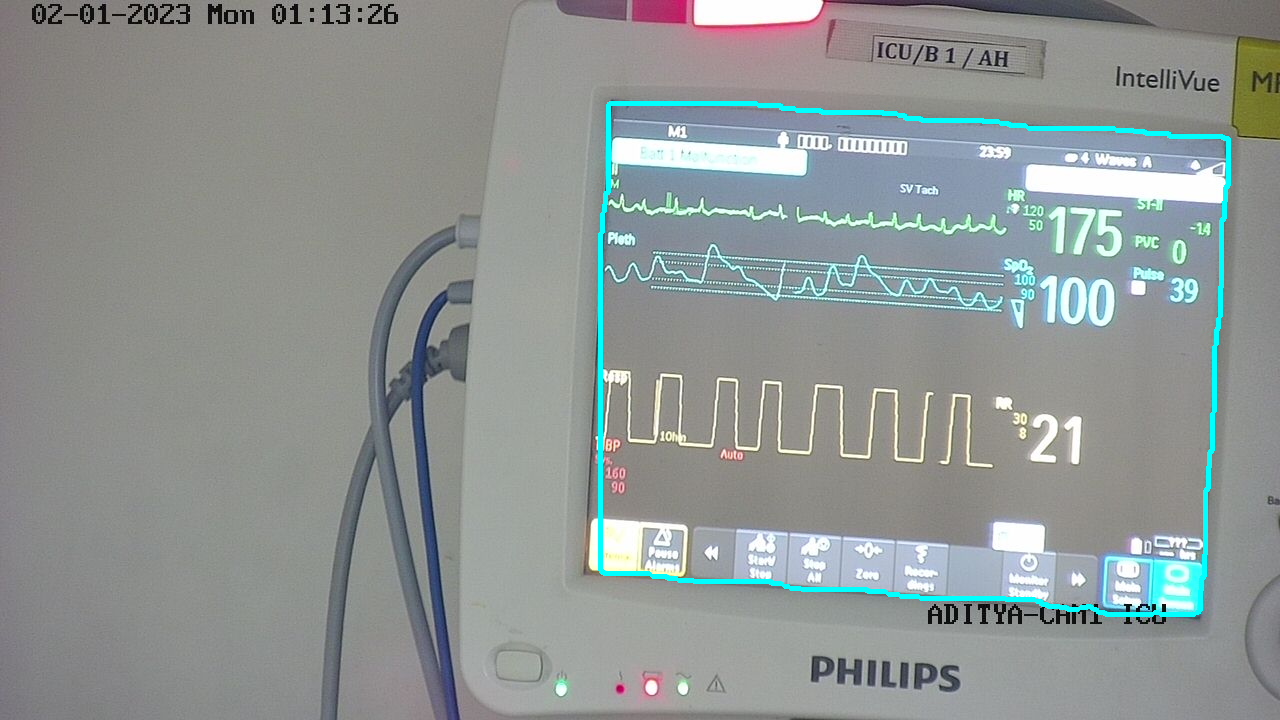

In [ ]:
mbox=getmbox('adityawarangal_icu_mon--01_2023_1_2_1_15_1.jpeg',cv2.imread('/content/quickbrownfoxx/adityawarangal_icu_mon--01_2023_1_2_1_15_1.jpeg'),12)
mbox
cv2_imshow(cv2.polylines(cv2.imread('/content/quickbrownfoxx/adityawarangal_icu_mon--01_2023_1_2_1_15_1.jpeg'),np.array([mbox],np.int32),isClosed=True,thickness=4,color=(255,255,0)))

In [ ]:
bbox=getbbox('image257.jpeg',9)
bbox

[[860, 175], [1138, 175], [1138, 423], [860, 423]]

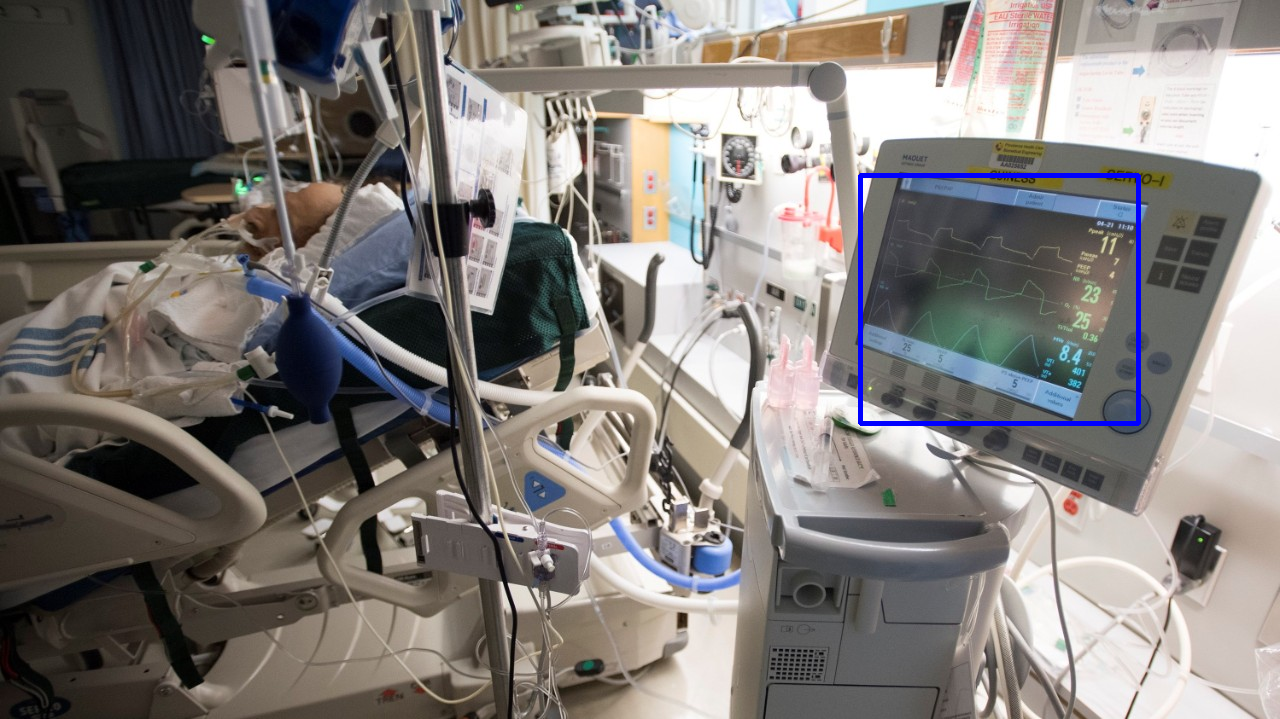

In [ ]:
test=cv2.imread('image257.jpeg')
cv2_imshow(cv2.polylines(test,np.array([bbox],np.int32),isClosed=True,color=(255,0,0),thickness=3))
cv2_imshow(cv2.polylines(test,np.array([mbox],np.int32),isClosed=True,color=(255,255,0),thickness=3))


In [ ]:
test2=cv2.imread('aastha_icu_mon--5_2023_1_2_18_0_0.jpeg')
cv2_imshow(cv2.polylines(test2,np.array([getcorners(bbox,mbox)],np.int32),isClosed=False,color=(255,0,0),thickness=3))

NameError: ignored

## Segmentation + Warping

### Setup & imports

In [ ]:
!git clone https://github.com/ultralytics/yolov5.git  # Cloning the repo 
!gdown "10FTRA1EBIbENR579vdam8CNPA0Zw5PMB&confirm=t"  # Downloading the weights for custom YOLOv5
!pip install -r ./yolov5/requirements.txt             # Installing the requirements

Cloning into 'yolov5'...
remote: Enumerating objects: 15064, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 15064 (delta 21), reused 26 (delta 11), pack-reused 15019
Receiving objects: 100% (15064/15064), 14.13 MiB | 18.13 MiB/s, done.
Resolving deltas: 100% (10320/10320), done.
Downloading...
From: https://drive.google.com/uc?id=10FTRA1EBIbENR579vdam8CNPA0Zw5PMB&confirm=t
To: /content/best.pt
100% 4.04M/4.04M [00:00<00:00, 164MB/s]
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.3 MB/s eta 0:00:00


In [ ]:
### SEGMENTATION IMPORTS

import yolov5.segment.predict as predict
import numpy as np
import os
import cv2
from google.colab.patches import cv2_imshow
import subprocess
import matplotlib.pyplot as plt
import timeit
import time
import torch
%matplotlib inline

#disable yolov5 logging
import logging
logging.getLogger('yolov5').setLevel(logging.WARN)


### Helper functions 

In [ ]:
# Helper functions

def plotim(im_list, title_list):  # To plot a list of images and their titles
  import math
  nrows = math.ceil(len(im_list)/3)
  fig, ax = plt.subplots(nrows, 3, figsize=(nrows*30, 50))
  if nrows==1:
    for i in range(len(im_list)):
      ax[i%3].imshow(im_list[i])
      ax[i%3].set_title(title_list[i], size=22)
  else:
    for i in range(len(im_list)):
      ax[i//3, i%3].imshow(im_list[i])
      ax[i//3, i%3].set_title(title_list[i], size=22)
  plt.show()   

# Get vertices of mask bounding polygon 
def get_mask_boundary_box(filename,image):
  file_ext = os.path.splitext(filename)[1]
  basename = str(os.path.basename(filename))
  bbox=list()
  try:
    with open(f'/content/yolov5/runs/predict-seg/exp/labels/{basename.rstrip(file_ext)}.txt') as f:
      fl=0
      t=[]
      for x in next(f).split():       #reading file
        if fl==0:
          fl+=1
          continue
        if fl%2==0:
          t.append(float(x)*image.shape[0])
          bbox.append(t.copy())
        else:
          t.append(float(x)*image.shape[1])
        if(fl%2==0):
          t.clear()
        fl+=1
  except:
     bbox = [[0,0], [0, image.shape[1]], [image.shape[0], 0], [image.shape[0], image.shape[1]]]
  return bbox 


def dis2(c,d):
  return c*c+d*d

def get_screen_corners(image,mbox):       #opencv corner coordinate function
  nim2=np.zeros((image.shape[0],image.shape[1],image.shape[2]))
  nim=cv2.fillConvexPoly(nim2.copy(),np.array(mbox,np.int32),color=(255,255,255))
  img=nim
  gray = cv2.cvtColor(np.float32(img), cv2.COLOR_BGR2GRAY)
  blurred = cv2.bilateralFilter(gray, 9, 75, 75)                          #smoothes out the noise in the image
  _, thresh = cv2.threshold(np.uint8(blurred), 0, 255, cv2.THRESH_OTSU)   #automatic image thresholding

  contours, _ = cv2.findContours(np.uint8(blurred), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contour = contours[0]

  perimeter = cv2.arcLength(contour, True)
  approx = cv2.approxPolyDP(contour, 0.05 * perimeter, True)

  dmin=10000000000
  ireq=-1
  for i in range(4):
    if dis2(approx[i][0][0],approx[i][0][1])<dmin:
      ireq=i
      dmin=dis2(approx[i][0][0],approx[i][0][1])
  return [approx[ireq][0],approx[(ireq-1+4)%4][0],approx[(ireq-2+4)%4][0],approx[(ireq-3+4)%4][0]]


def warp_image(image,corners):        #apply warping to the image
  cornersp = np.float32([corners[0], corners[1], corners[2], corners[3]])
  width, height = image.shape[1],image.shape[0]
  pts2 = np.float32([[0,0],[width,0],[width,height],[0,height]])
  matrix = cv2.getPerspectiveTransform(cornersp,pts2)
  output = cv2.warpPerspective(image,matrix,(width,height))
  return output


def run_segmentation_and_warping(impath):
  """
  Input:  impath -> Absolute path of the image we want to process
  Output: warped_image -> a np array of the warped+segmented image of the monitor
  """
  image = cv2.imread( impath )
  predict.run(weights='/content/best.pt',save_txt=True,source=impath,exist_ok=True,nosave=True)
  mbox=get_mask_boundary_box(impath,image)
  # seg_img = cv2.polylines(image.copy(),np.array([mbox],np.int32),isClosed=True,color=(255,255,0),thickness=3)
  corners=get_screen_corners(image,mbox)  #openCV corner function
  return warp_image(image,corners)

### Test block

In [ ]:
# # Test block

# # Downloading the ds
# !gdown 1aPcpumnmdIAtqEqqkRhlqVGkpQ_4wtHg
# !unzip -q small_test_dataset.zip


# # Test run
# import matplotlib.pyplot as plt

# im_path = '/content/small_test_dataset/adityawarangal_icu_mon--01_2023_1_3_14_15_1.jpeg'
# plt.imshow(plt.imread(im_path))
# plt.show()
# segim = run_segmentation_and_warping(im_path)
# plt.imshow(segim[:, :, ::-1])
# plt.show()